## Start up

In [1]:
import pandas as pd
import seaborn as sns
from enum import Enum     # for enum34, or the stdlib version
from pycaret.classification import *
from anonymizeip import anonymize_ip

class AnonTypes(Enum):
    BM = 0 # black marker 
    BI = 1 # bilateral classification
    NO = 2 # no anonymization
    
sample = 0
binary = 0

# anonymization flag
tlp_anonymization = AnonTypes.BI
ip_proto_anonymization = AnonTypes.BI
pkt_counter_anonymization = AnonTypes.BI
oct_counter_anonymization = AnonTypes.BI

In [2]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            if not (type(df[col][0])==list):
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])
                if float(num_unique_values) / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

In [3]:
df = pd.read_csv("../../NF-ToN-IoT.csv")

## Checks

### =================================================================

In [4]:
# Remove non-ipfix standardized features
# See: https://www.ntop.org/guides/nprobe/cli_options.html#netflow-v9-ipfix-format-t
# Thesis: Refer to table 2 for feature names and descriptions

df_ipfix = df[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']]
#df_ipfix['IPV4_SRC_ADDR'] = df_ipfix['IPV4_SRC_ADDR'].astype('category')
#df_ipfix['IPV4_DST_ADDR'] = df_ipfix['IPV4_DST_ADDR'].astype('category')

df_ipfix = optimize(df_ipfix, [])
df_ipfix.memory_usage()

Index                             128
L4_SRC_PORT                   5517096
L4_DST_PORT                   5517096
PROTOCOL                      1379274
IN_BYTES                      5517096
OUT_BYTES                     5517096
IN_PKTS                       5517096
OUT_PKTS                      5517096
TCP_FLAGS                     2758548
FLOW_DURATION_MILLISECONDS    5517096
Label                         1379274
Attack                        1379654
dtype: int64

In [5]:
if(binary):
    df_ = df_ipfix.drop("Attack", axis=1)
else:
    df_ = df_ipfix.drop("Label", axis=1)

# Sample data
if(sample):
    df_ = df_.sample(n=1000000)

## Feature Anonymization Functions

In [6]:
def anon_tlp(anon_type, df):
    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.5.1
        df['L4_SRC_PORT'] = [0 if int(x) <= 1023 else 1 for x in df['L4_SRC_PORT']]
        df['L4_DST_PORT'] = [0 if int(x) <= 1023 else 1 for x in df['L4_DST_PORT']]
    elif(anon_type == AnonTypes.BM):
        df['L4_SRC_PORT'] = 0
        df['L4_DST_PORT'] = 0
 
    return df
    
def anon_pkt_counters(anon_type, df): 
    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.4.2
        df['IN_PKTS'] = [0 if int(x) <= 2 else 1 for x in df['IN_PKTS']]
        df['OUT_PKTS'] = [0 if int(x) <= 2 else 1 for x in df['OUT_PKTS']]
    elif(anon_type == AnonTypes.BM): 
        df['IN_PKTS'] = 0
        df['OUT_PKTS'] = 0
    
    return df

def anon_octet_counters(anon_type, df): 
    median_bytes_in = df_['IN_BYTES'].median()
    median_bytes_out= df_['OUT_BYTES'].median()

    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.4.2
        df['IN_BYTES'] = [0 if int(x) <= median_bytes_in else 1 for x in df['IN_BYTES']]
        df['OUT_BYTES'] = [0 if int(x) <= median_bytes_out else 1 for x in df['OUT_BYTES']]
    elif(anon_type == AnonTypes.BM): 
        df['IN_BYTES'] = 0
        df['OUT_BYTES'] = 0
    
    return df

def anon_ip_proto(anon_type, df):
    grouped_protocols = [1, 6, 17] # 1, 6, and 17 for ICMP, UDP, and TCP 

    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.5.1
        df['PROTOCOL'] = [0 if int(x) in grouped_protocols else 1 for x in df['PROTOCOL']] 
    elif(anon_type == AnonTypes.BM): 
        df['PROTOCOL'] = 0
        
    return df

### Anonymization iterations 

In [7]:
#print(df_['L4_SRC_PORT'].value_counts())
df_ = anon_tlp(tlp_anonymization, df_)
df_ = anon_pkt_counters(pkt_counter_anonymization, df_)
df_ = anon_octet_counters(oct_counter_anonymization, df_)
df_ = anon_ip_proto(ip_proto_anonymization, df_)

df_.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Attack
0,1,0,0,0,0,0,0,24,327,Benign
1,1,1,0,0,0,0,0,0,0,Benign
2,1,1,0,0,0,0,0,0,0,Benign
3,0,0,0,1,0,0,0,0,0,Benign
4,1,1,0,0,0,0,0,0,0,Benign


### =================================================================

## Setup

In [8]:
#df_['ICMP_TYPE'] = df_['ICMP_TYPE'].astype(str)
#df_['ICMP_IPV4_TYPE'] = df_['ICMP_IPV4_TYPE'].astype(str)
categorical = ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'TCP_FLAGS']

for f in categorical:
    df_[f] = df_[f].astype('str')

#df_ = df_[['TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label']]

if(binary):
    session_binary = setup(df_, target = 'Label', experiment_name='binary', categorical_features = categorical, normalize=True, fix_imbalance=True)
else:
    session_multi = setup(df_, target = 'Attack', experiment_name='multiclass', categorical_features = categorical, normalize=True, fix_imbalance=True)

,Description,Value
0,Session id,1896
1,Target,Attack
2,Target type,Multiclass
3,Target mapping,"Benign: 0, backdoor: 1, ddos: 2, dos: 3, injection: 4, mitm: 5, password: 6, ransomware: 7, scanning: 8, xss: 9"
4,Original data shape,"(1379274, 10)"
5,Transformed data shape,"(3693553, 10)"
6,Transformed train set shape,"(3279770, 10)"
7,Transformed test set shape,"(413783, 10)"
8,Ordinal features,3
9,Numeric features,5


In [9]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.1948,0.5752,0.1948,0.3443,0.2380,0.1340,0.1654
1,0.1980,0.5791,0.1980,0.3393,0.2407,0.1394,0.1749
2,0.2557,0.6111,0.2557,0.5938,0.3168,0.1909,0.2324
3,0.2439,0.6030,0.2439,0.5182,0.3054,0.1779,0.2170
4,0.2389,0.5992,0.2389,0.5027,0.3008,0.1716,0.2103
5,0.2024,0.5800,0.2024,0.3780,0.2482,0.1411,0.1783
6,0.1945,0.5770,0.1945,0.3235,0.2362,0.1362,0.1967
7,0.2310,0.5947,0.2310,0.5186,0.2967,0.1638,0.1998
8,0.2074,0.5832,0.2074,0.4165,0.2551,0.1461,0.1849


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

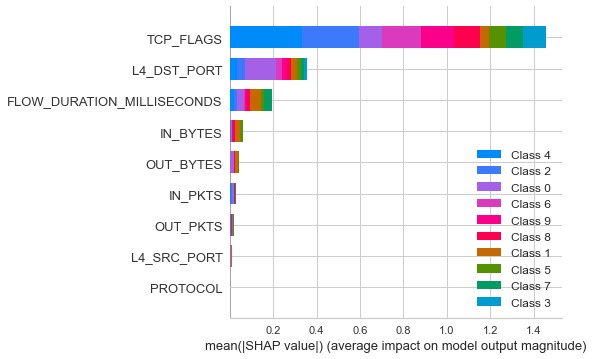

In [10]:
interpret_model(dt)